In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

import matplotlib.pyplot as plt

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from utils_local.misc import amro2title, amro2cute
import matplotlib.ticker as mtick


In [2]:
def empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv"):
    amro_prev_df = pd.read_csv(path_to_prev)
    gammas       = amro_prev_df[amro_prev_df.amro==amro][["prevalence_mean1", "prevalence_mean2", "prevalence_mean3"]].values / 100
    return np.squeeze(gammas)

def simulate_abm(f, f0, g, θ, model_settings):
    dates_simulation      = model_settings["dates_simulation"]
    x                     = f0(θ)
    observations          = np.full((len(dates_simulation), model_settings["k"], model_settings["m"]), np.nan)
    observations[0, :, :] = g(0, x, θ)

    for t, date in enumerate(dates_simulation[1:]):
        x                       = f(t, x, θ)
        observations[t+1, :, :] = g(t, x, θ)
    return observations

def create_obs_infer(obs_sim, idx_infer, dates, model_settings, resample="W-Sun"):
    # obs_sim \in R^{[k x T x m]} as required by pompjax
    infer_df = pd.DataFrame(index=dates)
    for i in range(model_settings["k"]) :
        infer_df['y'+str(i+1)]   = obs_sim[i, :, idx_infer]
        infer_df['oev'+str(i+1)] = 1 +(0.2 * infer_df['y'+str(i+1)].values)**2
    infer_df                     = infer_df.resample(resample).sum()
    infer_df.index.values[-1]    = model_settings["dates"][-1]
    return infer_df

In [3]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
ward2buildingid        =  {row.ward: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_47200/2265996033.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [4]:

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "n"                 : movement_df.mrn_id.unique().shape[0],
                    "k"                 : movement_df.cluster.unique().shape[0],
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : len(np.unique(list(wardid2buildingid.values()))),
                    "k"                 : len(np.unique(list(wardid2buildingid.values())))# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates


In [5]:
id_run       = 0
amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

path_to_amro = os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" )

posterior_df = pd.DataFrame()
for amro in amro_search:
    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")
    os.makedirs(os.path.join(results2_dir,    "amro_inferences", "abm"), exist_ok=True)

    gammas        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")


    for idx_gamma, gamma in enumerate(gammas):
        path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}")
        inference = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))
        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        Nif       = θpost.shape[-1]

        ρ_post = θpost[0, :, :, :].mean(-2).flatten()
        β_post = θpost[1, :, :, :].mean(-2).flatten()

        post_df             = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter"])
        post_df["value"]    = np.concatenate([ρ_post, β_post])
        post_df["param"]    = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
        post_df["if_iter"]  = flatten_list([list(range(Nif)) * model_settings["m"] ] * 2 )
        post_df["ens_id"]   = flatten_list([[i] * Nif for i in range( model_settings["m"])] * 2)
        post_df["gamma"]    = gamma
        post_df["amro"]     = amro
        posterior_df        = pd.concat([posterior_df, post_df])


Running IF-EAKF for amro:  E. coli
Running IF-EAKF for amro:  K. pneumoniae
Running IF-EAKF for amro:  P. aeruginosa
Running IF-EAKF for amro:  MSSA
Running IF-EAKF for amro:  MRSA
Running IF-EAKF for amro:  S. epidermidis
Running IF-EAKF for amro:  E. faecalis
Running IF-EAKF for amro:  E. faecium


In [131]:
path_to_save_fig = os.path.join(results2_dir, "amro_inferences", "abm", "figures")

def add_subplot_axes(ax, rect, axisbg='w'):
    fig    = plt.gcf()
    box    = ax.get_position()
    height = box.height
    width  = box.width

    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure    = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)
    x              = infig_position[0]
    y              = infig_position[1]
    width         *= rect[2]
    height        *= rect[3]

    subax       = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)

    return subax


rect1      = (0.25,  0.12,
                0.4,  0.4)
rect2      = (0.5,   0.08,
                0.4, 0.4)
rect3      = (0.5,   0.08,
                0.4, 0.4)
rect4      = (0.5,   0.08,
                0.4, 0.4)
rect6      = (0.5,   0.08,
                0.4, 0.4)
rect7      = (0.5,   0.08,
                0.4, 0.4)
rect8      = (0.5,   0.08,
                0.4, 0.4)

rect  = [rect1, rect2, rect3, rect4, None, rect6, rect7, rect8]


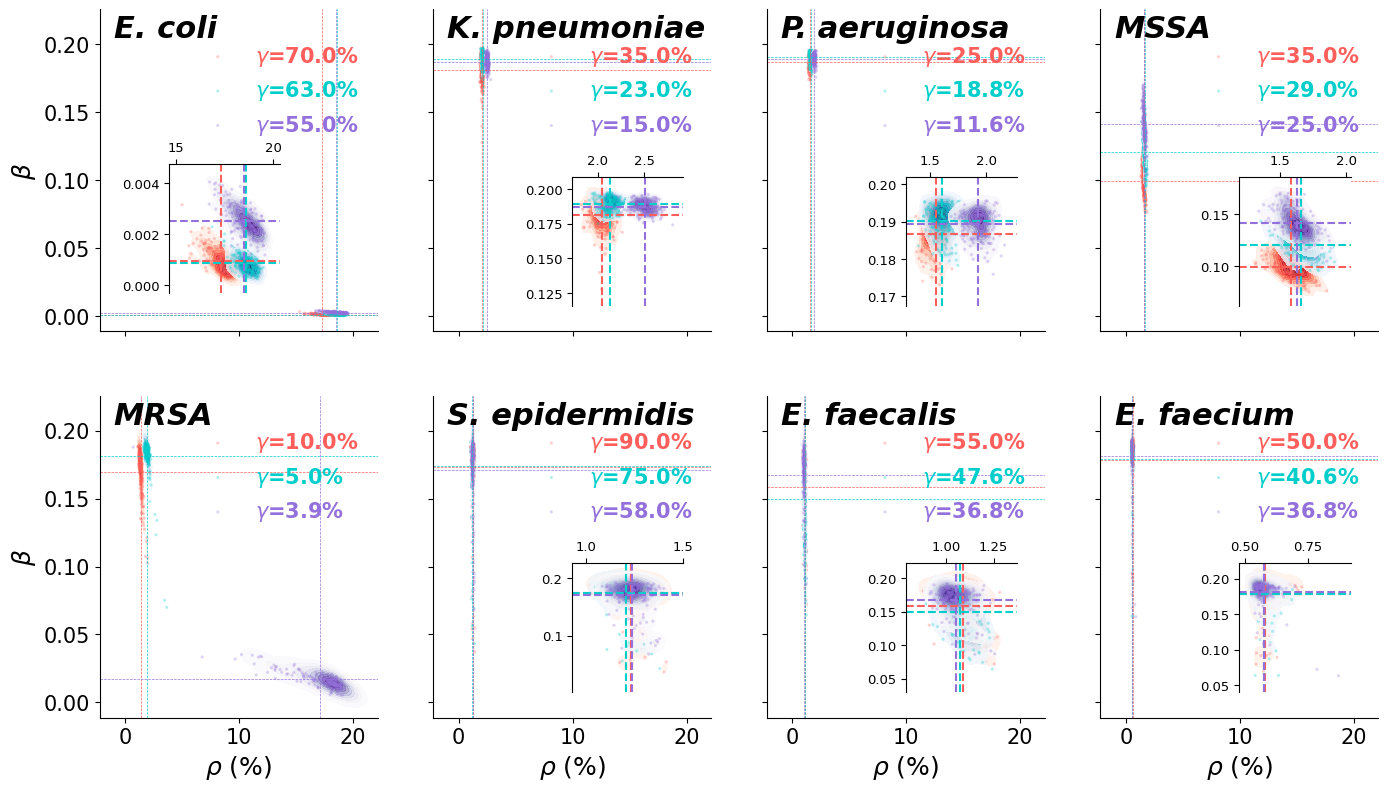

In [134]:
from diagnostic_plots import convergence_plot
from utils_local import plot_utils
import seaborn as sns


COLORS_GAMMA = ["#ff5e5b", "#00cecb", "mediumpurple"]
CMAPS_GAMMA  = ["Reds", "Blues", "Purples"]
v_df = posterior_df[posterior_df["if_iter"] == Nif-1]

fig, ax = plt.subplots(2, 4, figsize=(16.5, 9.2), sharex=True, sharey=True)

for idx_axi, axi in enumerate(ax.flatten()):
    amro    = amro_search[idx_axi]
    amro_df = v_df[v_df.amro==amro]
    gammas  = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    for idx_g, gamma in enumerate(gammas):
        rho_df  = amro_df.query(f"gamma=={gamma} and param=='ρ'")
        beta_df = amro_df.query(f"gamma=={gamma} and param=='β'")

        sns.kdeplot(ax    = axi,
                    x     = rho_df["value"].values * 100,
                    y     = beta_df["value"].values,
                    cmap  = CMAPS_GAMMA[idx_g],
                    fill  = True,
                    alpha = 0.7)

        axi.scatter(rho_df["value"].values * 100,
                    beta_df["value"].values,
                    fc        = COLORS_GAMMA[idx_g],
                    ec        = None,
                    alpha     = 0.3,
                    s         = 5,
                    label     = r"$\gamma$="+"{:0.1f}%".format(gamma*100))

        axi.axhline(y     = np.mean(beta_df["value"].values),
                    ls    = "--",
                    lw    = 0.5,
                    color = COLORS_GAMMA[idx_g])

        axi.axvline(x     = np.mean(rho_df["value"].values*100),
                    ls    = "--",
                    lw    = 0.5,
                    color = COLORS_GAMMA[idx_g])

    axi.set_ylim((-0.011310953055567037, 0.2257557217477729))
    axi.set_xlim((-2.2376656192686055, 22.171308067653385))

    axi.text(x       = -1.0,
            y        = 0.205,
            s        = f"{amro2title(amro)}",
            style    = 'italic',
            weight   = 'bold',
            color    = "k",
            fontsize = 22)

    l = axi.legend(loc             = "upper right",
                    frameon        = False,
                    prop           = {"weight": 'bold'},
                    bbox_to_anchor = [1, 0.95])

    for idx_t, text in enumerate(l.get_texts()):
        text.set_color(COLORS_GAMMA[idx_t])

    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_ylabel(None)
    axi.set_xlabel(None)

    if idx_axi != 4:
        ax_zoomed          = add_subplot_axes(axi, rect[idx_axi], axisbg='w')

        for idx_g, gamma in enumerate(gammas):
            rho_df  = amro_df.query(f"gamma=={gamma} and param=='ρ'")
            beta_df = amro_df.query(f"gamma=={gamma} and param=='β'")

            sns.kdeplot(ax     = ax_zoomed,
                        x      = rho_df["value"].values * 100,
                        y      = beta_df["value"].values,
                        cmap   = CMAPS_GAMMA[idx_g],
                        fill   = True,
                        alpha  = 0.8)

            ax_zoomed.scatter(rho_df["value"].values * 100,
                                beta_df["value"].values,
                                fc        = COLORS_GAMMA[idx_g],
                                ec        = None,
                                alpha     = 0.3,
                                s         = 5,
                                label     = r"$\gamma$="+"{:0.1f}%".format(gamma*100))

            ax_zoomed.axhline(y       = np.mean(beta_df["value"].values),
                                ls    = "--",
                                color = COLORS_GAMMA[idx_g])

            ax_zoomed.axvline(x   = np.mean(rho_df["value"].values*100),
                                ls    = "--",
                                color = COLORS_GAMMA[idx_g])

            ax_zoomed.spines['bottom'].set_visible(False)
            ax_zoomed.spines['right'].set_visible(False)
            ax_zoomed.xaxis.set_label_position('top')
            ax_zoomed.xaxis.tick_top()

ax[0, 0].set_ylabel(r"$\beta$")
ax[1, 0].set_ylabel(r"$\beta$")

for i in range(4):
    ax[1, i].set_xlabel(r"$\rho$ (%)")


In [141]:
from eval.calibration import calibration
from utils import create_df_response

def create_sim_df(sim_samples, model_settings):
    """ Sample from the posterior simultion

    Args:
        sim_samples: Array with shape (k: num_observations, m: num_samples, T: length of simulation)
        model_settings: _description_
    """
    k, m , T = sim_samples.shape
    y = sim_samples

    sim_df = pd.DataFrame()
    for ki in range(model_settings["k"]):
        df           = pd.DataFrame(np.squeeze(y[ki, :, :]).flatten(), columns=["value"])
        df["date"]   = flatten_list([list(model_settings["dates_simulation"])] * model_settings["m"])
        df["ens_id"] = flatten_list([[mi]*model_settings["T"] for mi in range(model_settings["m"])])
        df           = df.set_index(["date", "ens_id"]).unstack([1]).resample("W-Sun").sum().stack().reset_index()
        df["yi"]     = ki
        sim_df       = pd.concat([sim_df, df])
    return sim_df

def create_obs_building_amro(amro, model_settings, ward2building_dict, path_to_data, resample="W-Sun", p_oev=0.2):
    k                     = model_settings["k"]
    amro_df               = pd.read_csv(path_to_data, parse_dates=["date"]).drop(columns=["Unnamed: 0"])
    amro_df               = amro_df[amro_df["amro"]==amro]

    amro_df["buildingid"] = amro_df["ward_total"].map(ward2building_dict)

    amro_df               = amro_df.groupby(["date", "buildingid"]).sum(numeric_only=True).unstack([1]).resample(resample).sum(numeric_only=True).stack().reset_index()
    amro_df["obs_name"]   = amro_df["buildingid"].map({i: f"y{i+1}" for i in range(k)})
    amro_df               = pd.pivot(amro_df, index="date", columns="obs_name", values="num_positives").reset_index()
    for i in range(k):
        amro_df['oev'+str(i+1)] = 1 +(p_oev * amro_df['y'+str(i+1)].values)**2
    amro_df = amro_df.set_index("date")
    return amro_df

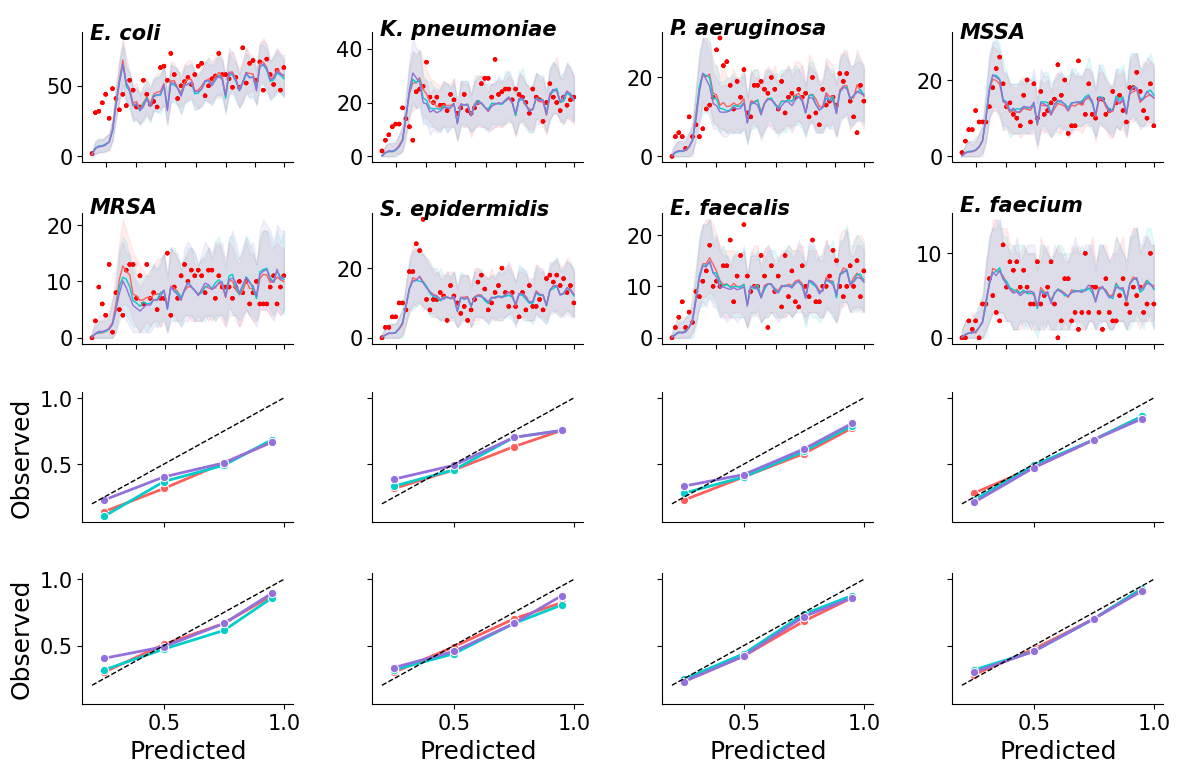

In [149]:
from matplotlib import dates as mdates
import seaborn as sns

COLORS_GAMMA = ["#ff5e5b", "#00cecb", "mediumpurple"]


fig     = plt.figure(constrained_layout=True, figsize=(12.5, 7.2))
subfigs = fig.subfigures(2, 1, hspace=0.05, wspace=0.05, height_ratios=[0.5, 0.5])

axes   = subfigs[0].subplots(2, 4, sharex="col")
axes_c = subfigs[1].subplots(2, 4, sharex=True, sharey=True)

for idx_amro, amro in enumerate(amro_search):
    gammas       = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")
    obs_df       = create_obs_building_amro(amro, model_settings, ward2buildingid, path_to_amro)
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")

    hosp_calibration_df = pd.DataFrame()
    for idx_gamma, gamma in enumerate(gammas):
        path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}")
        sim_post        = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}sim_post.npz"))
        sim_df          = create_sim_df(sim_post["y"].transpose(1, 2, 0), model_settings)

        hosp_df      = sim_df.groupby(["date", "ens_id"]).sum()[["value"]].reset_index()
        hosp_samples = hosp_df.pivot(index="date", columns="ens_id", values="value").to_numpy()
        hosp_samples = np.expand_dims(hosp_samples, 0)

        c_df                = calibration(hosp_samples, np.expand_dims(obs_df[[f"y{i+1}" for i in range(model_settings["k"])]].sum(axis=1).to_numpy(), 0))
        c_df["observation"] = "agg"
        c_df["amro"]        = amro
        c_df["gamma"]       = gamma

        hosp_calibration_df = pd.concat([hosp_calibration_df, c_df])
        hosp_df = create_df_response(np.squeeze(hosp_samples), time   = len(if_settings["assimilation_dates"]),
                                                                dates = if_settings["assimilation_dates"])
        axi     = axes.flatten()[idx_amro]

        axi.plot(if_settings["assimilation_dates"], hosp_df["mean"], color=COLORS_GAMMA[idx_gamma], lw=1.0, label=r"$\gamma$_{}".format(idx_gamma))
        axi.fill_between(if_settings["assimilation_dates"], hosp_df["low_95"], hosp_df["high_95"], color=COLORS_GAMMA[idx_gamma], alpha=0.1)
        #axi.fill_between(if_settings["assimilation_dates"], hosp_df["low_50"], hosp_df["high_50"], color=COLORS_GAMMA[idx_gamma], alpha=0.2)
        y_hosp = obs_df[[f"y{i+1}" for i in range(model_settings["k"])]].sum(axis=1)
        axi.scatter(if_settings["assimilation_dates"], y_hosp,
                                    ec=None, fc="r", label="Data", s=10)

        axi.tick_params(which='both', axis='x', labelrotation=75)
        axi.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)
        axi.legend().remove()
        axi.set_ylabel(None)
        axi.set_xlabel(None)

    axi.text(x       = 18290,
            y        = np.maximum(hosp_df["high_95"].max(), np.max(y_hosp))+1,
            s        = f"{amro2title(amro)}",
            style    = 'italic',
            weight   = 'bold',
            color    = "k")


    ax_c = axes_c.flatten()[idx_amro]
    sns.lineplot(ax     = ax_c,
                data    = hosp_calibration_df,
                x       = "quantiles",
                y       = "proportion_inside",
                marker  = "o",
                hue     = "gamma",
                palette = COLORS_GAMMA,
                lw      = 2)

    iden = np.arange(0.2, 1.1, 0.1)
    ax_c.plot(iden, iden, color="k", lw=1.0, ls="--")
    ax_c.spines['right'].set_visible(False)
    ax_c.spines['top'].set_visible(False)
    ax_c.legend().remove()
    ax_c.legend().remove()

axes_c[0, 0].set_ylabel("Observed")
axes_c[1, 0].set_ylabel("Observed")

for i in range(4):
    axes_c[1, i].set_xlabel("Predicted")

fig.suptitle("Calibration at hospital level.")
plt.tight_layout()


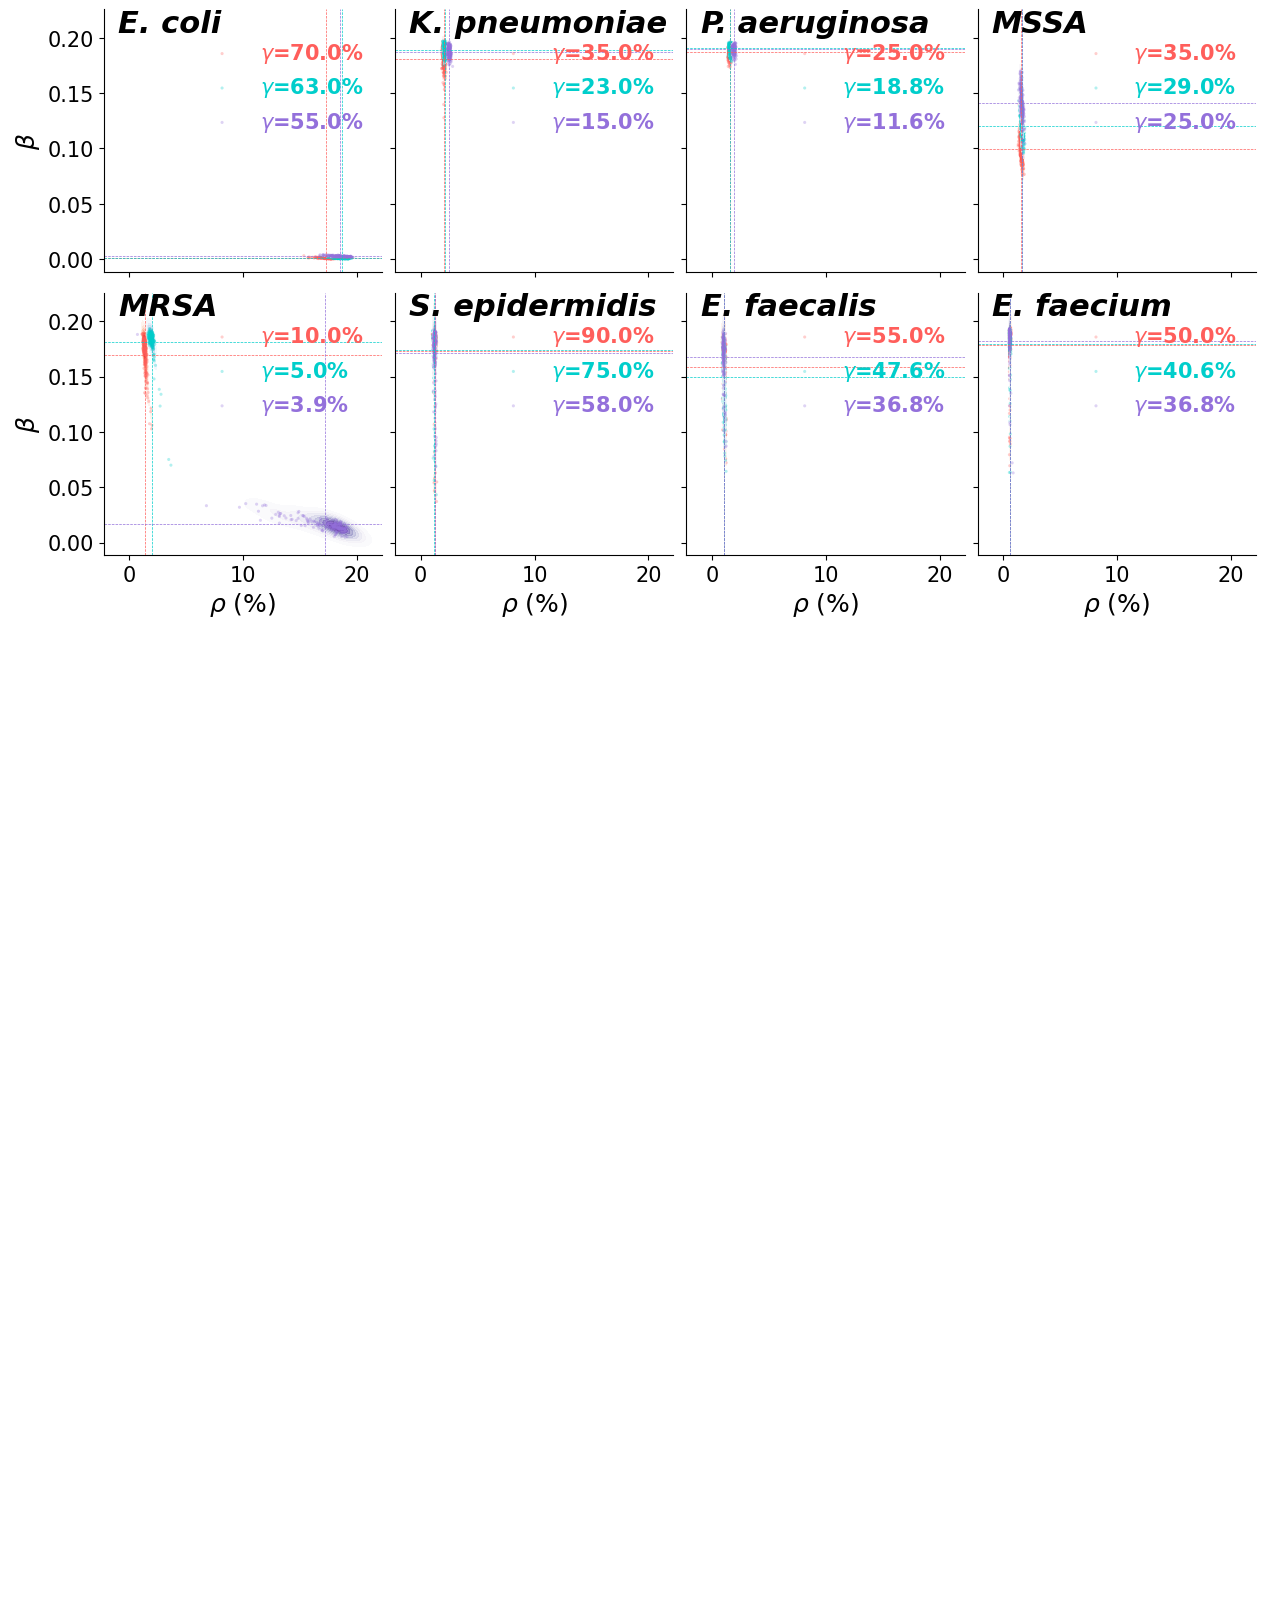

In [151]:
fig     = plt.figure(constrained_layout=True, figsize=(12.5, 16))
subfigs = fig.subfigures(2, 1, hspace=0.07, wspace=0.01, height_ratios=[0.4, 0.6])



######################################## Pannel A ######################################################################
axes1   = subfigs[0].subplots(2, 4, sharex=True, sharey=True)
for idx_axi, axi in enumerate(axes1.flatten()):
    amro    = amro_search[idx_axi]
    amro_df = v_df[v_df.amro==amro]
    gammas  = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    for idx_g, gamma in enumerate(gammas):
        rho_df  = amro_df.query(f"gamma=={gamma} and param=='ρ'")
        beta_df = amro_df.query(f"gamma=={gamma} and param=='β'")

        sns.kdeplot(ax    = axi,
                    x     = rho_df["value"].values * 100,
                    y     = beta_df["value"].values,
                    cmap  = CMAPS_GAMMA[idx_g],
                    fill  = True,
                    alpha = 0.7)

        axi.scatter(rho_df["value"].values * 100,
                    beta_df["value"].values,
                    fc        = COLORS_GAMMA[idx_g],
                    ec        = None,
                    alpha     = 0.3,
                    s         = 5,
                    label     = r"$\gamma$="+"{:0.1f}%".format(gamma*100))

        axi.axhline(y     = np.mean(beta_df["value"].values),
                    ls    = "--",
                    lw    = 0.5,
                    color = COLORS_GAMMA[idx_g])

        axi.axvline(x     = np.mean(rho_df["value"].values*100),
                    ls    = "--",
                    lw    = 0.5,
                    color = COLORS_GAMMA[idx_g])

    axi.set_ylim((-0.011310953055567037, 0.2257557217477729))
    axi.set_xlim((-2.2376656192686055, 22.171308067653385))

    axi.text(x       = -1.0,
            y        = 0.205,
            s        = f"{amro2title(amro)}",
            style    = 'italic',
            weight   = 'bold',
            color    = "k",
            fontsize = 22)
    l = axi.legend(loc             = "upper right",
                    frameon        = False,
                    prop           = {"weight": 'bold'},
                    bbox_to_anchor = [1, 0.95])
    for idx_t, text in enumerate(l.get_texts()):
        text.set_color(COLORS_GAMMA[idx_t])
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_ylabel(None)
    axi.set_xlabel(None)

    if idx_axi != 4:
        ax_zoomed          = add_subplot_axes(axes1.flatten()[idx_axi], rect[idx_axi], axisbg='w')
        for idx_g, gamma in enumerate(gammas):
            rho_df  = amro_df.query(f"gamma=={gamma} and param=='ρ'")
            beta_df = amro_df.query(f"gamma=={gamma} and param=='β'")

            sns.kdeplot(ax     = ax_zoomed,
                        x      = rho_df["value"].values * 100,
                        y      = beta_df["value"].values,
                        cmap   = CMAPS_GAMMA[idx_g],
                        fill   = True,
                        alpha  = 0.8)

            ax_zoomed.scatter(rho_df["value"].values * 100,
                                beta_df["value"].values,
                                fc        = COLORS_GAMMA[idx_g],
                                ec        = None,
                                alpha     = 0.3,
                                s         = 5,
                                label     = r"$\gamma$="+"{:0.1f}%".format(gamma*100))
            ax_zoomed.axhline(y       = np.mean(beta_df["value"].values),
                                ls    = "--",
                                color = COLORS_GAMMA[idx_g])
            ax_zoomed.axvline(x   = np.mean(rho_df["value"].values*100),
                                ls    = "--",
                                color = COLORS_GAMMA[idx_g])
            ax_zoomed.spines['bottom'].set_visible(False)
            ax_zoomed.spines['right'].set_visible(False)
            ax_zoomed.xaxis.set_label_position('top')
            ax_zoomed.xaxis.tick_top()

axes1[0, 0].set_ylabel(r"$\beta$")
axes1[1, 0].set_ylabel(r"$\beta$")
for i in range(4):
    axes1[1, i].set_xlabel(r"$\rho$ (%)")

##############################################################################################################


######################################## Pannel A ######################################################################
